In [23]:
# Clear workspace
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
from scipy.stats import sem, percentileofscore
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

base_dir = "~/Desktop/hif2gene"
model_output_dir = "/Users/jason.wang/Desktop/hif2gene/data/model_outputs/hrd" # change path


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
seed = 360
np.random.seed(seed)
outcome = 'HRD'

In [25]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(base_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters

Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Load in Null Distributions

AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE
[-0.032098165585068755, -0.023375839989401778, -0.02326852969934788, -0.02295877820748343, -0.02167942841225971, -0.020050241736066923, -0.015095823755650382, -0.01477714053494808, -0.012538381020967786, -0.012338071891236433, -0.010337182285217005, -0.010201571065391974, -0.008584703029790903, -0.006375887586791654, -0.0030973329569569216, -0.0022712339086418958, -0.0010283377431038144, -0.0005292071686945789, -0.00045447354175008695, -0.00023934869735019735, -0.00018499504383153953, -0.00010876067515188559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

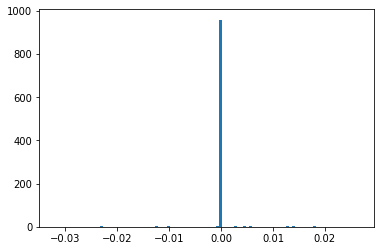

49.85
100.0


In [26]:
# Change path
hif_null_distributions = pkl.load(open("{0}/hif_beta_null_distributions.pkl".format(model_output_dir), "rb"))

for k, v in hif_null_distributions.items():
    print(k)
    print(sorted(v))
    plt.hist(v, bins=100)
    plt.show()
    print(percentileofscore(v, 0))
    print(percentileofscore(v, 0.1))
    break

## Load in HIF Betas

In [27]:
betas_df = pd.read_csv("{0}/coefficients/pancancer/{1}_model_ensemble.csv".format(model_output_dir, outcome))
betas_df = betas_df[['HIF', 'Beta', 'Cluster']]

# Remove zeros
betas_df = betas_df[betas_df['Beta'] != 0.0]
betas_df


,HIF,Beta,Cluster
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,0.004734,2
45,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN ESI_0080_HE,0.000915,9
46,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN STROMA_HE,0.000249,9
47,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN TUMOR_HE,0.000786,9
105,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF PLASMA IN ESI_0080_HE,0.001508,9
...,...,...,...
563,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF NECROSIS_HE,0.006262,2
568,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,0.001947,2
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.004944,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.000584,9


## Compute P-Values

In [28]:
# One-sided
p_values = []
for index, row in betas_df.iterrows():
    hif = row['HIF']
    beta = row['Beta']
    null_distribution = hif_null_distributions[hif]
    
    if (beta > 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 100.0):
            percentile -= 0.1 # precision to 1/10th of a percentage point
        p_value = (100.0 - percentile)/100.0
        p_values.append(p_value)
    elif (beta < 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 0.0):
            percentile += 0.1
        p_value = percentile/100.0
        p_values.append(p_value)
    
    print(beta, p_value)

0.004734295680099452 0.01
0.0009153491315505699 0.007999999999999972
0.00024928057292462235 0.012000000000000028
0.0007861591142313496 0.01
0.001507748998184335 0.005999999999999943
0.00032384781519648897 0.012999999999999972
0.005316594584552414 0.007999999999999972
0.0002087199344460445 0.02
0.00040282041168768884 0.020999999999999942
0.0007028167457552064 0.007999999999999972
0.008564886367654009 0.005999999999999943
0.0034582951856736628 0.0040000000000000565
0.0030469705267751786 0.007000000000000029
-0.0014788022210461256 0.012
0.001478802221046107 0.014000000000000058
-0.00930208076523855 0.012
0.009302080462719074 0.012000000000000028
-0.003118893024839529 0.024
-0.0010270950966358944 0.008
-0.0019053228117327523 0.004
-0.003777869370308228 0.016
0.00534979681716406 0.005
0.0037475966887330213 0.0029999999999999714
-0.0020388303942776593 0.017
0.0008689764231067832 0.007000000000000029
-0.03814638284385536 0.001
-0.005451899508659634 0.001
-0.012739434652896946 0.001
0.01825716

In [29]:
betas_df['P-Value'] = p_values
betas_df

,HIF,Beta,Cluster,P-Value
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,0.004734,2,0.010
45,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN ESI_0080_HE,0.000915,9,0.008
46,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN STROMA_HE,0.000249,9,0.012
47,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN TUMOR_HE,0.000786,9,0.010
105,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF PLASMA IN ESI_0080_HE,0.001508,9,0.006
...,...,...,...,...
563,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF NECROSIS_HE,0.006262,2,0.004
568,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,0.001947,2,0.009
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.004944,9,0.005
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.000584,9,0.012


## Empirical Brown's Method

In [30]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/pancancer.HRD_Score.joined.USE.csv".format(base_dir))
df = df.iloc[:,1:]

# Normalize HIFs and define X, y
X = df.iloc[:,1:608]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.600393,1.314603,-0.470257,1.659651,1.304770,-0.580343,0.233843,0.580343,0.405602,0.407832,...,0.638931,0.619329,-0.063004,0.671587,0.535652,0.448336,1.769037,0.479384,0.033078,0.243184
1,0.863030,2.096933,-0.395098,2.210694,1.773248,-0.628743,0.652124,0.628743,0.250413,0.383649,...,-0.180693,-0.239796,-0.236229,0.075815,0.069252,-0.001200,-0.395294,-0.473244,-0.458866,-0.481679
2,-0.513853,-0.204282,-0.350836,-0.185654,-0.394826,-0.536974,0.691347,0.536974,-0.676347,0.234995,...,-0.358800,-0.423970,-0.402874,-0.338006,-0.335380,-0.395445,-0.508411,-0.530255,-0.505365,-0.539241
3,-0.110824,0.958567,-0.490868,1.084462,0.572254,-0.945521,0.940345,0.945521,0.938871,1.127052,...,-0.419376,-0.430131,-0.363722,-0.467676,-0.428800,-0.466331,-0.299173,-0.533674,-0.558148,-0.564142
4,-1.163427,-1.211280,-0.448139,-1.041544,-1.257102,-2.239275,-1.890234,2.239275,-2.324071,-2.908494,...,-0.613223,-0.670793,-0.524901,-0.703385,-0.611705,-0.666810,-0.611897,-0.624257,-0.592509,-0.634120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,0.126742,0.709691,1.197476,3.252447,1.972062,-1.445762,-1.240951,1.445762,-1.104070,-0.183960,...,2.277700,2.006456,-0.292112,1.154643,2.230424,1.859121,-0.383775,0.550236,1.548791,1.420033
1529,0.396801,0.136285,0.248653,-0.340307,0.022124,0.882013,0.385631,-0.882013,0.494139,0.633432,...,-0.082406,-0.171075,-0.477718,-0.589961,-0.549303,-0.600437,-0.548635,-0.040430,0.034010,-0.033517
1530,0.753693,0.869846,2.338960,1.018699,1.015467,-0.124042,-0.042650,0.124042,-0.069744,-0.547949,...,0.225645,0.221268,-0.355022,-0.266171,-0.286886,-0.340964,0.181433,0.475347,0.841627,0.818366
1531,-0.198252,0.040041,2.957599,-0.071306,-0.152141,-0.146863,0.637177,0.146863,-0.286363,-0.481863,...,-0.036412,-0.116762,-0.169973,0.186521,0.058245,0.006438,-0.227035,0.539031,0.515871,0.461102


In [31]:
# Filter dataset to only include HIFs associated with non-zero betas
X_normalized_filterd = X_normalized.iloc[:, list(betas_df.index)]
X_normalized_filterd.columns = betas_df['HIF']
X_normalized_filterd

HIF,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN STROMA_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN TUMOR_HE,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF PLASMA IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF PLASMA IN STROMA_HE,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN STROMA_HE,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN TUMOR_HE,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF PLASMA IN ESI_0080_HE,...,REGION PROPERTIES: MINOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,REGION PROPERTIES: NUMBER OF REGIONS OF NECROSIS_HE,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF NECROSIS_HE,REGION PROPERTIES: TOTAL FILLED AREA (MM2) OF NECROSIS_HE,REGION PROPERTIES: TOTAL MAJOR AXIS LENGTH (MM) OF NECROSIS_HE,REGION PROPERTIES: TOTAL MINOR AXIS LENGTH (MM) OF NECROSIS_HE,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,TOTAL [PLASMA CELLS] IN [STROMA]_HE,TOTAL [PLASMA CELLS] IN [TUMOR]_HE
0,-0.470257,0.210069,0.025001,0.125305,0.288024,-0.059566,1.987852,0.563167,1.050515,0.280310,...,-0.323626,-0.548919,-0.450616,-0.465473,-0.693127,-0.685458,-0.638327,0.479384,0.033078,0.243184
1,-0.395098,-0.439777,-0.428569,-0.449141,-0.740567,-0.669574,-0.718777,-0.614881,-0.597998,-0.722157,...,-0.360506,-0.388028,-0.381820,-0.393498,-0.413114,-0.395766,-0.417882,-0.473244,-0.458866,-0.481679
2,-0.350836,-0.503068,-0.486470,-0.502377,-0.642719,-0.566189,-0.694482,-0.594806,-0.599501,-0.627618,...,0.149914,-0.435047,-0.370383,-0.351680,-0.511715,-0.495471,-0.500123,-0.530255,-0.505365,-0.539241
3,-0.490868,-0.532053,-0.530676,-0.542745,-0.769287,-0.729199,-0.895397,-0.830498,-0.861542,-0.742300,...,-0.401979,-0.482750,-0.463239,-0.484397,-0.646975,-0.637924,-0.612256,-0.533674,-0.558148,-0.564142
4,-0.448139,-0.562090,-0.548244,-0.565442,-0.696676,-0.710933,-0.736160,-0.792247,-0.801764,-0.672405,...,-0.495708,0.162354,-0.419076,-0.443444,-0.139205,-0.080932,-0.258061,-0.624257,-0.592509,-0.634120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,1.197476,2.211823,2.797958,2.717614,0.302769,0.561370,0.108763,0.721036,0.723360,0.276518,...,0.224679,0.164406,0.906409,1.124091,1.042799,0.987957,0.779299,0.550236,1.548791,1.420033
1529,0.248653,-0.210167,0.018421,0.000704,-0.173391,-0.082580,-0.146541,0.140742,0.057133,-0.233115,...,1.368109,1.959515,0.210533,0.310830,0.583298,0.431407,0.917676,-0.040430,0.034010,-0.033517
1530,2.338960,0.087241,0.300540,0.277507,-0.073596,0.279751,0.205414,0.900153,0.821690,-0.116970,...,0.838075,6.657848,2.881540,2.487611,3.548927,3.112071,5.984315,0.475347,0.841627,0.818366
1531,2.957599,0.077900,0.167661,0.149150,0.447143,0.554680,0.777687,1.059518,0.955719,0.354421,...,5.575128,5.750120,3.911072,3.520240,2.916307,2.616582,5.317208,0.539031,0.515871,0.461102


In [32]:
# HIFs are highly-correlated; thus P-values are correlated / dependent
# Apply the Empirical Brown's Method to combine P-values per HIF cluster
combined_pvals = cf.combine_p_values(np.array(betas_df['Cluster']), betas_df.set_index('HIF'), 
                                     X_normalized_filterd, p_val_col='P-Value')
combined_pvals

array([1.88091247e-04, 1.45485003e-12, 6.93810676e-04, 5.87474837e-13,
       9.11613660e-07, 1.25577937e-04])

In [33]:
len(combined_pvals)

6

In [34]:
significant, ebm_q_values = ht.bh_correction(combined_pvals, alpha=0.05) # Q-values = corrected P-values

In [35]:
combined_corrected_pvals = pd.DataFrame({
    "Cluster Group": sorted(list(set(betas_df['Cluster']))),
    "Combined P-Value": combined_pvals,
    "Q-Value": ebm_q_values # Corrected + Combined P-Value)
})
combined_corrected_pvals

,Cluster Group,Combined P-Value,Q-Value
0,2,1.880912e-04,2.257095e-04
1,4,1.454850e-12,4.364550e-12
2,9,6.938107e-04,6.938107e-04
3,12,5.874748e-13,3.524849e-12
4,13,9.116137e-07,1.823227e-06
5,16,1.255779e-04,1.883669e-04
